# Machine Learning Demonstrations

In this notebook, we showcase how to use the kdb+/q clustering library, contained within the ML-Toolkit, and to plot outputs using embedPy. Below we demonstrate how to use each algorithm contained within the toolkit and how to use the library in conjunction with real-world data.

<div class="alert alert-danger">
To run the below notebook, ensure that dependencies specified in <b>requirements.txt</b> have been correctly installed.
</div>

# Clustering

Clustering is a technique used in both data mining and machine learning to group similar data points together in order to identify patterns in their distributions.

The task of clustering data can be carried out using a number of algorithms. The algorithms defined in the toolkit work based on distinct clustering methodologies namely; connectivity-based, centroid-based or density-based models. Each type of algorithm defines clusters based on:

-   **Centroid-based** - distances from single points which represent the cluster.
-   **Density-based** - clusters being within a certain distance of each other and in defined concentrations.
-   **Connectivity-based** - distances between individual data points.

Each algorithm works by iteratively joining, separating or reassigning points until the desired number of clusters have been achieved.

The process of finding the correct cluster for each data point is a case of trial and error, where parameters must be altered in order to find the optimum solution.

## Machine Learning Toolkit

The ML-Toolkit contains general use utilities, an implementation of the FRESH (Feature Extraction based on Scalable Hypothesis tests) algorithm, cross validation functions and clustering algorithms. The primary purpose of these libraries are to provide kdb+/q users with access to commonly-used ML functions for preprocessing data, extracting features and scoring results.

The toolkit is used throughout this notebook and can be loaded using the below syntax.

In [1]:
\l ml-awdm/ml.q
.ml.loadfile`:clust/init.q

## Sections

This notebook is split into 2 distinct sections, which cover the different algorithms contained in the toolkit, along with a real-world example.

[**Algorithms**](#Algorithms):
1. Centroid-based: [K-Means](#K-Means)
2. Density-based: [DBSCAN](#DBSCAN), [Affinity Propagation](#Affinity-Propagation)
3. Connectivity-based: [Hierarchical](#Hierarchical), [CURE](#CURE)

**Real-World Example**:
4. [Chocolate Bar Ratings](#Chocolate-Bar-Ratings)

---

## Load data and scripts

The below cell loads in graphics functions used throughout this notebook.

In [2]:
\c 20 100
\l ../utils/graphics.q

Throughout this notebook, we cluster data from the `sklearn` and `pyclustering` sample libraries and then visualize the results using `matplotlib`.

Each of the libraries are imported using embedPy, as shown below.

In [3]:
/ sklearn samples
skldata:.p.import`sklearn.datasets
blobs:skldata[`:make_blobs;<]
moons:skldata[`:make_moons;<]
iris :skldata[`:load_iris;<]

/ pyclustering samples
pcldata:.p.import`pyclustering.samples.definitions
pclutil:.p.import`pyclustering.utils
fcps_samp:pcldata`:FCPS_SAMPLES
smpl_samp:pcldata`:SIMPLE_SAMPLES
read_samp:pclutil`:read_sample

---

<a id='Affinity-Propagation'></a>
# Algorithms

In this section we showcase how to use the algorithms contained within the ML-Toolkit. We start with descriptions of centroid- and density-based clustering algorithms, followed by connectivity-based algorithms.

Before continuing through the notebook, it is worth noting that for simplicity:
- Default parameters have been used throughout.
- The algorithms below have been applied to 2D data. All algorithms, except affinity propagation, can be applied in higher dimensional examples.

---

<a id='K-Means'></a>
# K-Means

Clustering data with the k-means algorithm begins with the selection of *k* data points as cluster centres. Data points are then assigned to the nearest cluster centres.

The algorithm follows an iterative refinement process which will run *n* times, updating the cluster centres and assigned points during each iteration.

Advantages of k-means include:
- The simplicity of the algorithm, both to implement and run, makes it extremely efficient and easy to understand
- Creating centroids is an easy way to perform data reduction

### Inputs

To apply k-means to q data, the function `.ml.clust.kmeans` must be called using the following arguments:
- `d` - data in matrix form
- `k` - number of clusters
- `n` - number of iterations
- `i` - boolean indicating initialisaton type: both select k points from the dataset as cluster centres, `1b` initialises the [k-means++](https://en.wikipedia.org/wiki/K-means%2B%2B) algorithm, `0b` selects *k* random points
- `df` - distance function, e.g. ```e2dist`edist`mdist``

### Example

In this example, we show how k-means can be used to identify clusters in datasets with no apparent structure.

The algorithm is able to cluster the data into evenly spaced clusters in comparison to other denisty or distance based algorithms.

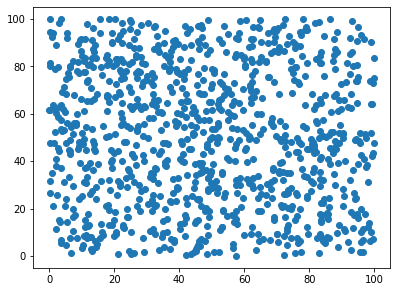

In [4]:
\S 20
d1:1000 2#2000?100.
plt[`:scatter]. flip d1;
plt[`:show][];

In this case, we want to identify `3` clusters across `100` iterations of the algorithm using euclidean squared distances. Note that in this case, k-means will be initialized using kmeans++.

51 154768


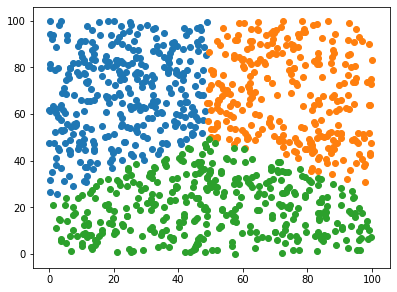

In [5]:
\ts r1:.ml.clust.kmeans[d1;3;100;1b;`e2dist]
{plt[`:scatter]. flip x}each exec pts by clt from r1;
plt[`:show][];

---

<a id='DBSCAN'></a>
## DBSCAN (Density-Based Spatial Clustering of Applications with Noise)

The DBSCAN algorithm groups points together that are closely packed in areas of high-density. Any points in low-density regions are seen as outliers.

DBSCAN does not require the user to pass in the number of clusters, it will determine the optimum number for you. This decision is based on a minimum number of points per cluster and an epsilon radius which describes the neighbourhood of each point, which must both be passed in as inputs.

Advantages of DBSCAN include:
- The number of clusters does not need to be known prior to use
- The algorithm is extremely useful for anomaly detection, and will return outliers as a separate cluster

### Inputs

DBSCAN is called using the function `.ml.clust.dbscan` which takes the followning arguments:
- `d` - data in matrix form
- `df`- distance function, e.g. ```e2dist`edist`mdist``
- `p` - minimum number of points in neighbourhood
- `e` - epsilon radius

### Example

Below shows how DBSCAN can be used to cluster data in odd shapes, such a crescent moons.

Distance-based models would struggle to correctly classify datasets like the one below as clusters are in close proximity and so points could easily be included in the wrong cluster.

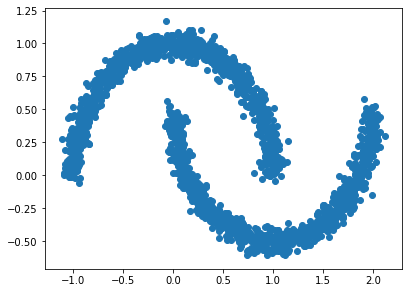

In [6]:
d2:moons[`n_samples pykw 2000;`noise pykw 0.05]0
plt[`:scatter]. flip d2;
plt[`:show][];

Density based models like DBSCAN are able to distinguish between the clusters given that points in each are densely packed.

Euclidean squared distances have been used for this example, with a minimum of `6` points required per cluster and a neighbourhood radius of `0.05`.

338 29018496


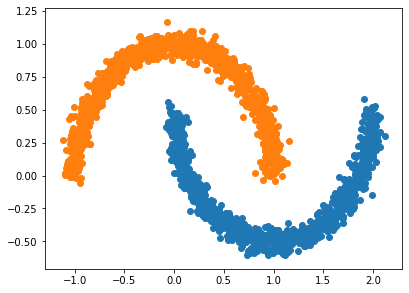

In [7]:
\ts r2:.ml.clust.dbscan[d2;`e2dist;6;.05]
{plt[`:scatter]. flip x}each exec pts by clt from r2;
plt[`:show][];

---

<a id='Affinity-Propagation'></a>
## Affinity Propagation

The affinity propagation works by grouping data based on the similarity between points. It then finds *k* exemplars which best represent the points in each cluster.

Similarly to DBSCAN, the algorithm does not require the user to input the number of clusters and will determine the optimum solution by exchanging real-valued messages between points until a high-valued set of exemplars are produced.

A damping coefficient is used to reduce the availability and responsibility of messages passed between points, while the preference value is used to set the diagonal values of the similarity matrix.

Advantages of affinity propagration include:
- The number of clusters does not need to be known prior to use
- The algorithm is highly scalable and can be applied to large similarity matrices

### Inputs

Affinity propagation can be applied to data using `.ml.clust.ap` which takes the followning arguments:
- `d` - data in matrix form
- `dmp` - damping coefficient (0-1)
- `p` - preference value - symbol (```min`max`med`` etc.) or float (`0f`, `-1f`, etc.)
- `b` - boolean flag, `1b` plot clusters each iteration, `0b` plot final iteration, `()` no iteration

### Example

In the example below we create "blobs" using the `sklearn` samples library. There are 200 points contained in the dataset and the random seed has been set so that results can be replicated.

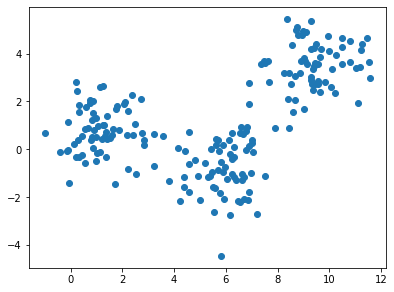

In [8]:
d3:blobs[`n_samples pykw 200;`random_state pykw 449]0
plt[`:scatter]. flip d3;
plt[`:show][];

Below we demonstrate using `.ml.clust.ap` and plot each cluster connected to the associated exemplar.

In the example, `0.9` is passed as the damping coefficient, while `min` is used to calculate the diagonal of the similarity matrix. Additionally, `0b` is used to only plot the final clusters.

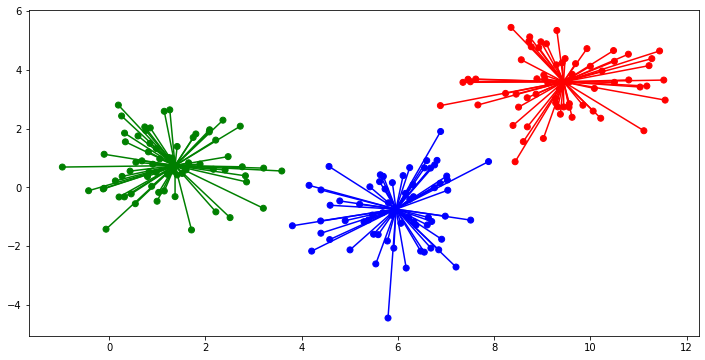

420 4126288


In [9]:
\ts r1:.ml.clust.ap[d3;.9;`min;0b];

---

<a id='Hierarchical'></a>
## Hierarchical Clustering

As the name suggests, hierarchical clustering algorithms create hierarchies of clusters. The implementation described here follows an agglomerative approach, where each data point is initially treated as its own cluster.

There are 5 possible linkages in hierarchical clustering:
- Single
- Complete
- Average
- Centroid
- Ward

Euclidean, Euclidean squared or Manhattan distances can be used with each linkage, except for ward which only works with Euclidean squared distances.

Similarly to CURE, the q and C k-d trees can be used for the single and centroid implementations.

At each step, the two closest clusters (defined by the linkage) are merged until only one cluster remains, which contains all of the data points. Results are usually represented by a dendrogram, used to suggest the “appropriate” number of clusters in the data. 

Advantages of hierarchical clustering include:
- The algorithms produce a dendrogram structure, which is extremely informative compared to other algorithms.
- The different methods available within hierarchical clustering make it applicable to a wide range of datasets.

### Inputs

To create a dendrogram, the function `.ml.clust.dgram` is called which takes the followning arguments:
- `d` - data in matrix form
- `df`- distance function, e.g. ```e2dist`edist`mdist``
- `lf`- linkage function, e.g. ```single`complete`average`centroid`ward ``

Given that dendrograms do not actually return lists of clustered data points, the function `ml.clust.hc` has been provided to allow users to define the number of clusters to return. The same parameters are used, plus extra parameter `k` for the number of desired clusters.

### Example

For simplicity, we only showcase some of the hierarchical linkages below. The function `plot` from `graphics.q` has been implemented to vizualise the clustered data and associated dendrograms.

The first example uses ward linkage with euclidean squared distances. Blobs are generated as before, using the `sklearn` samples library. `200` datapoints are used and a random state is again chosen.

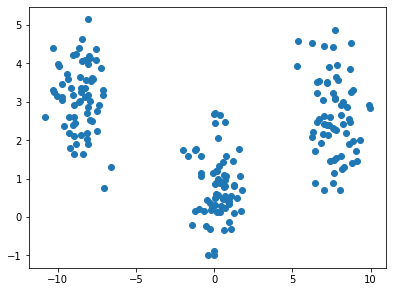

In [10]:
d4:blobs[`n_samples pykw 200;`random_state pykw 394]0
plt[`:scatter]. flip d4;
plt[`:show][];

In the first case, we demostrate how to use ward linkage in conjunction with euclidean squared distances to find 3 clusters in the data.

`()` is passed in as the 4th argument to the `plot` function, indicating to plot both the dendrogram and clusters.

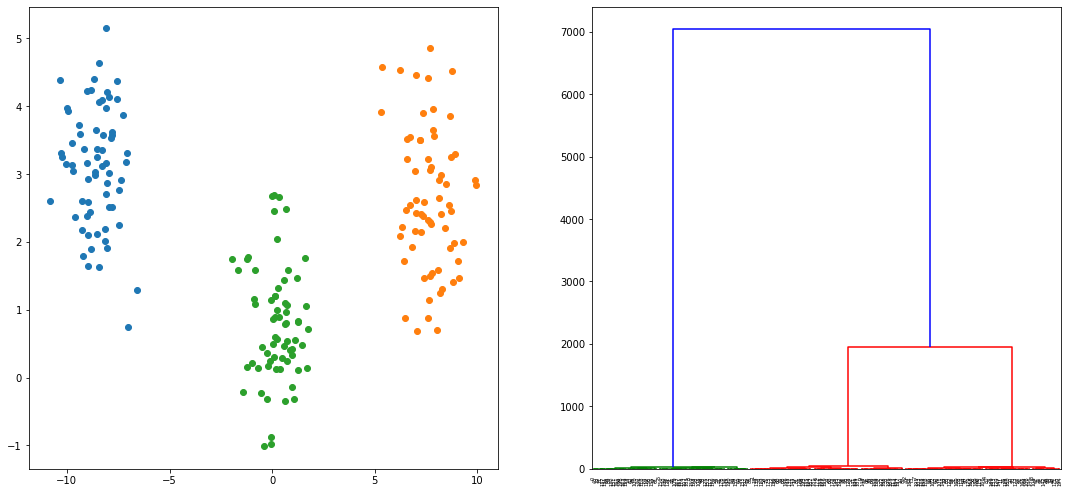

2810 166752


In [11]:
\ts plot[d4;3;`e2dist;`ward;()]

In the second case, complete linkage is used in conjunction with manhattan distances. We see that a different dendrogram is produced compared to the above due to the difference in linkage methods.

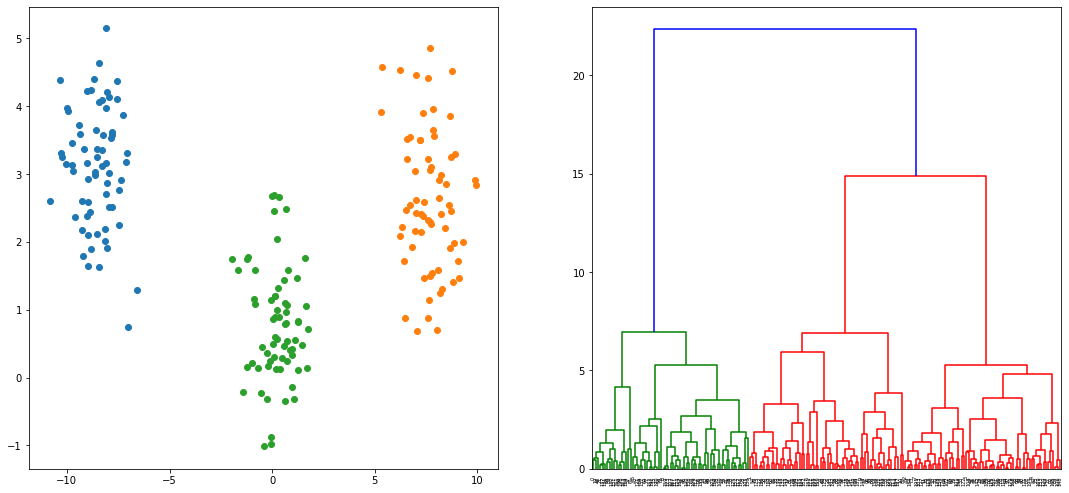

2864 862080


In [12]:
\ts plot[d4;3;`mdist;`complete;()]

---

<a id='CURE'></a>
## CURE (Clustering Using REpresentatives)

CURE clustering is a distance-based technique used to deal with datasets containing outliers and clusters of varying sizes and shapes.

Each cluster is represented by a specified number of representative points, chosen by taking the the most scattered points in each cluster and compressing them towards the cluster centre by a fixed amount.

In the implementation below, both q and C implementations of a k-dimensional (k-d) tree are available to store the representative points of each cluster (more information [here](https://code.kx.com/v2/ml/toolkit/clustering/kdtree)).

Advantages of CURE include:
- The use of a k-dimensional tree make the algorithm extremely efficient and highly scalable.
- The use of compression allows CURE to perform well in cases where the dataset provided contains outliers or has clusters of varying sizes and shapes.

### Inputs

In the cell below we demonstrate how to cluster data using the CURE algorithm. `.ml.clust.cure` is called with the following arguments:
- `d` - data in matrix form
- `k` - number of clusters
- `r` - number of representative points
- `i` - dictionary of inputs:
    - `df` - distance function, e.g. ```e2dist`edist`mdist``
    - `c` - compression
    - `b` - k-d tree boolean, `1b` for C, `0b` for q
    - `s` - output boolean, `1b` returns k-d tree dictionary, `0b` returns results table

<div class="alert alert-danger">
If <b>i</b> is passed an empty list, default parameters will be used.
    
In the default case, the q implementation of CURE will be run using euclidean squared distances, zero compression and a table will be output.
</div>

### Example

The below code creates a dataset of points belonging to 4 distinct clusters, 3 of which share the same centre. Most clustering algorithms do not perform well when presented with data in concentric circles. 

Note that the process has been random seeded so that results can be replicated.

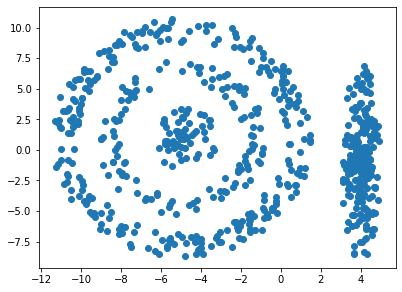

In [13]:
\S 20
dsc:{[n;r;s](r+n?s-r)*/:(cos;sin)@\:4*n?acos 0}
d5 :flip(-5 1)+(1 1.5)*dsc[1000; 0;1.8],'dsc[2000;3.1;4.2],'dsc[4000;5.2;6.5]
d5,:flip(4 -1)+(1 8)*dsc[4000; 0;1.]
d5@:neg[700&count d5]?count d5
plt[`:scatter]. flip d5;
plt[`:show][];

By using representative points, CURE is able to perform well when applied to these kinds of datasets.

The below applies CURE to the dataset, selecting `4` clusters, using `50` representative points and the default parameters for `i`. Results are then plotted using `matplotlib`.

3813 183152


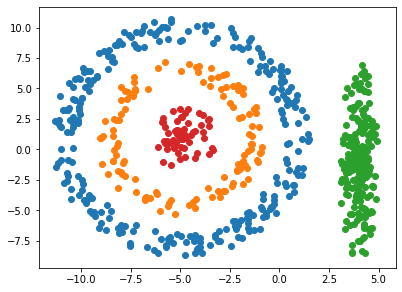

In [14]:
\ts r5:.ml.clust.cure[d5;4;50;()]
{plt[`:scatter]. flip x}each exec pts by clt from r5;
plt[`:show][];

---

# Real-World Example

<a id='Chocolate-Bar-Ratings'></a>
## Chocolate Bar Ratings

In the example below, we look at the kaggle [Chocolate Bar Ratings dataset](https://www.kaggle.com/rtatman/chocolate-bar-ratings), compiled by Brady Brelinski, the founder of the Manhattan Chocolate Society.

The dataset contains around 1,800 expert ratings for individual chocolate bars collected between 2006-2017. There is a focus on plain dark chocolate, with information on the origin and cocoa content of each bar produced. We will look specifically at the features for **cocoa percentage**, **rating** and **review date** of each chocolate bar.

Each bar is rated using the below scale, from worst to best:
1. **Unpleasant** - mostly unpalatable
2. **Disappointing** - passable, but contains at least 1 significant flaw
3. **Satisfactory** to 3.75. **Praiseworthy** - well made, with special qualities
4. **Premium** - superior flavor development, character and style
5. **Elite** - transcending beyond the ordinary limits

Where ratings are based on 4 main factors: *flavor, texture, aftermelt* and *overall opinion*, with flavor being the most important.

The aim in this example is to detect any outliers contained in the dataset using the clustering library contained in the ML-Toolkit. Additonal utility functions have also been defined below.

In [15]:
/ utils
mode:{$[98h~t:type x;i.mode each flip x;99h~t;i.mode each x;i.mode x]}
i.mode:{n?max n:count each group x}
describe_mode:{(key[i],`mode)!value[i:.ml.describe x],mode x}

### Load data

In the below cell, we load in the chocolate dataset and return the shape of the features of interest, namely `cocoa_pcnt`, `rating`, `review_dt`.

<div class="alert alert-danger">
The data loaded in below has been preprocessed prior to use in this notebook to remove punctuation characters, convert null `bean_typ characters to <i>"Unknown"</i> and change column names to those more appropriate for q.
</div>

In [16]:
-1"Full dataset:\n";
show 5#cocoa:("SSISSSIFF";(),",")0:`:../data/cocoa.csv

-1"\nRelevant columns:\n";
show 5#d:select cocoa_pcnt,rating,review_dt from cocoa

-1"\nRelevant column info:\n";
show describe_mode d

Full dataset:

company company_loc ref  bean_origin broad_bean_origin bean_typ review_dt cocoa_pcnt rating
-------------------------------------------------------------------------------------------
AMorin  France      1876 AguaGrande  SaoTome           Unknown  2016      0.63       3.75  
AMorin  France      1676 Kpime       Togo              Unknown  2015      0.7        2.75  
AMorin  France      1676 Atsane      Togo              Unknown  2015      0.7        3     
AMorin  France      1680 Akata       Togo              Unknown  2015      0.7        3.5   
AMorin  France      1704 Quilla      Peru              Unknown  2015      0.7        3.5   

Relevant columns:

cocoa_pcnt rating review_dt
---------------------------
0.63       3.75   2016     
0.7        2.75   2015     
0.7        3      2015     
0.7        3.5    2015     
0.7        3.5    2015     

Relevant column info:

     | cocoa_pcnt rating    review_dt
-----| ------------------------------
count| 1795       1795   

We can see that the majority of reviews were carried out in 2015, with most bars receiving a pretty averge score of 3.5. The focus on dark chocolate is also apparent given that most bars selected contain around 70% cocoa mass.

### Prepare data

Given that the three features of interest vary in scales, it is important to standardize the data before passing it to a clustering algorithm. Below we apply the standard scaler function contained within the ML-Toolkit.

In [17]:
5#s:.ml.stdscaler d

cocoa_pcnt rating     review_dt
-------------------------------
-1.376022  1.180231   1.255692 
-0.2686652 -0.9121291 0.913975 
-0.2686652 -0.3890391 0.913975 
-0.2686652 0.6571409  0.913975 
-0.2686652 0.6571409  0.913975 


At this stage it is useful to visualize the data to see if any outliers are apparent.

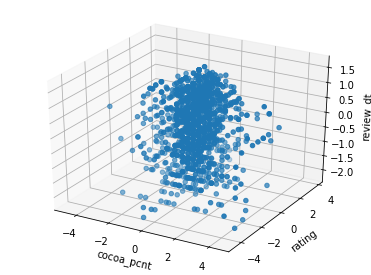

In [18]:
fig:plt[`:figure][];
.p.import[`mpl_toolkits.mplot3d]`:Axes3D;
ax:fig[`:add_subplot][111;`projection pykw"3d"];
ax[`:scatter]. value flip s;
ax[`:set_xlabel](sc:cols s)0;
ax[`:set_ylabel]sc 1;
ax[`:set_zlabel]sc 2;
plt[`:show][];

The plot makes clear that most data is clumped together in one obvious cluster, with a couple of sparse outliers present.

### Cluster data

It is now possible to apply clustering methods to the data. We have chosen to use the DBSCAN algorithm, contained within the ML-Toolkit, as this algorithm is commonly used in anomaly detection.

3146 1851055568


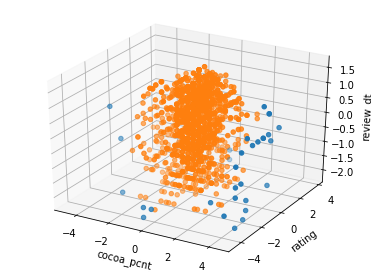


Outliers:

cocoa_pcnt rating review_dt
---------------------------
0.7        5      2007     
0.7        5      2006     
1          1.75   2010     
1          1.5    2006     
1          1.5    2009     

Outliers info:

     | cocoa_pcnt rating   review_dt
-----| -----------------------------
count| 31         31       31       
mean | 0.8977419  2.330645 2010.226 
std  | 0.1794382  1.015273 3.23223  
min  | 0.42       1f       2006i    
q1   | 0.82       1.5      2007f    
q2   | 1f         2f       2010f    
q3   | 1f         2.875    2013f    
max  | 1f         5f       2016i    
mode | 1f         1.5      2013i    


In [19]:
/ cluster data
\ts r:.ml.clust.dbscan[flip value flip s;`e2dist;10;2]

/ plot clusters
fig:plt[`:figure][];
ax:fig[`:add_subplot][111;`projection pykw"3d"];
{ax[`:scatter]. flip x}each c:exec pts by clt from r;
ax[`:set_xlabel]sc 0;
ax[`:set_ylabel]sc 1;
ax[`:set_zlabel]sc 2;
plt[`:show][];

-1"\nOutliers:\n";
show 5#outliers:d exec idx from r where clt=-1
-1"\nOutliers info:\n";
show describe_mode outliers

The algorithm has detected 31 outliers within the dataset. These have been grouped together into cluster `-1`.

Below we plot the distribution of each feature in the 31 outliers to see if any clear trends exist within the data.

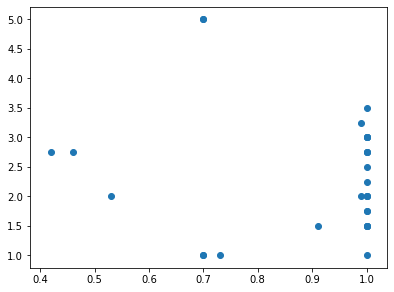

In [20]:
/ bar + below
plt[`:scatter][outliers`cocoa_pcnt;outliers`rating];
plt[`:show][];

The majority of outliers were reviewed in 2013, with pretty low ratings, ranging mainly from 1-3. The most prominent feature of the plots is the number of bars present with 100% cocoa content.

We can check this against the number of 100% bars in the entire dataset:

In [21]:
exec count i from cocoa where cocoa_pcnt=1

20


All of the bars with 100% dark chocolate contained in the dataset appear in our outliers.

We can look specifically at the ratings and review date for those values:

In [22]:
\c 25 100
`rating xasc select from outliers where cocoa_pcnt=1

cocoa_pcnt rating review_dt
---------------------------
1          1      2008     
1          1.5    2006     
1          1.5    2009     
1          1.5    2012     
1          1.5    2010     
1          1.75   2010     
1          1.75   2013     
1          2      2014     
1          2      2008     
1          2      2007     
1          2.25   2013     
1          2.5    2013     
1          2.75   2013     
1          2.75   2013     
1          2.75   2016     
1          3      2013     
1          3      2008     
1          3      2015     
1          3      2015     
1          3.5    2013     


In [23]:
\c 20 110
select from(cocoa exec idx from r where clt=-1)where cocoa_pcnt=1

company                company_loc ref  bean_origin                   broad_bean_origin bean_typ          r..
-----------------------------------------------------------------------------------------------------------..
ArtisanduChocolat      UK          486  Venezuela                     Venezuela         Unknown           2..
Bonnat                 France      81   OneHundred                                      Unknown           2..
BougaCacaoTulicorp     Ecuador     341  ElOroHaciendadeOro            Ecuador           ForasteroArriba   2..
CAmaro                 Italy       1185 Ecuador                       Ecuador           Unknown           2..
ClaudioCorallo         SaoTome     252  Principe                      SaoTomePrincipe   Forastero         2..
Coppeneur              Germany     817  EcuadorPuristique             Ecuador           Unknown           2..
Domori                 Italy       1109 IL100HSanJose                 Venezuela         Criollo           2..
Habitual  

In [24]:
`cocoa_pcnt xasc select from outliers where cocoa_pcnt<1

cocoa_pcnt rating review_dt
---------------------------
0.42       2.75   2013     
0.46       2.75   2010     
0.53       2      2006     
0.7        5      2007     
0.7        5      2006     
0.7        1      2007     
0.7        1      2006     
0.73       1      2007     
0.91       1.5    2008     
0.99       2      2006     
0.99       3.25   2012     


It looks as though the bars with higher cocoa percentage actually produce lower than average ratings as a whole compared to the other bars in the dataset.

---